Mounting google drive:


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


import libraries:

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os

check if gpu is enabled

In [ ]:
# Confirms enabled GPU
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


set seed to get consistent results over multiple runs

In [ ]:
# To get consistent results
np.random.seed(69) 

utility functions:

In [ ]:
def get_training_df():
    training_df = pd.read_csv(r'/content/gdrive/My Drive/vcs/training.csv')
    return training_df


def get_test_df():
    test_df = pd.read_csv(r'/content/gdrive/My Drive/vcs/test.csv')
    return test_df

def drop_na_values(df):
    dropped_df = df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)
    return dropped_df

def get_images(df):
    images = df['Image']
    images_list = []
    for img in images:
        images_list.append(np.array([int(x) for x in img.split(' ')]).reshape((96, 96)))
    return np.array(images_list) / 255.0   # Normalize pixel values between (0, 1)

# Delete image row to turn dataset to an array
def drop_pixel_values(df):
    new_df = df.drop(['Image'], axis=1)
    return new_df

def drop_x_values(df):
    lst = []
    for i in df:
        if 'x' in i:
            lst.append(i)
    return df.drop(columns=lst, axis=1)
  
def image_mirroring(df):
    all_images = get_images(df)
    return np.array([np.fliplr(image) for image in all_images])

def x_feature_mirroring(df, width=96):
    x_features = {}
    for column in df:
        if 'x' in column:
            temp = np.array(df[column])
            temp = width - temp
            x_features[column] = temp
    return x_features

def data_augmentation(df):
    augmented_images = image_mirroring(df)
    augmented_xes = x_feature_mirroring(df, width=96)

    # Drops x values to feed new augmented x values to dataframe
    df = drop_x_values(df)
    del df['Image']
    for name, j in zip(augmented_xes, range(0, 30, 2)):
        df.insert(loc=j, column=name, value=augmented_xes[name])

    augmented_df = df

    return augmented_df, augmented_images

# Shows image and keypoints at given index
def show_image(x_dataset, y_dataset, index): 
    img = np.array(x_dataset[index]).reshape((96, 96))
    keypoints = y_dataset[index]
    x_keypoints = keypoints[::2]
    y_keypoints = keypoints[1::2]
    plt.imshow(img, cmap='gray')
    plt.scatter(x_keypoints, y_keypoints)
    plt.show()

# Augment data by using Gaussian blur and linear constrast.
def augment_data_by_gb_and_lc(images_array, keypoints_array):
    # Setup an augmenter that applies linear contrast to all images and
    # Gaussian blur only to the 80% of them
    augmenter = iaa.Sequential([iaa.LinearContrast((0.6, 1.5)), 
                        iaa.Sometimes(
        0.80, iaa.GaussianBlur(sigma=(0., 2.0)))])
    
    a_imgs_accumulator = []
    a_kp_accumulator = []

    # Augment every image and rebuild the augmented arrays of images and
    # keypoints.
    # Note that in this case keypoints stay the same
    for image, keypoints in zip(images_array, keypoints_array):
      resulting_image = augmenter(image=image)
      a_imgs_accumulator.append(resulting_image)
      a_kp_accumulator.append(keypoints)

    return np.asarray(a_imgs_accumulator), np.asarray(a_kp_accumulator)

  Facial keypoint detection

In [ ]:
# Get training dataframe
training_dataframe = get_training_df()

# Drop rows which have NaN values
training_dataframe_dropped = drop_na_values(training_dataframe)

# Extract images from dataframe
training_images = get_images(training_dataframe_dropped)

# Extract keypoints from dataframe
training_dataframe_keypoints = drop_pixel_values(training_dataframe_dropped)
training_array = training_dataframe_keypoints.to_numpy(dtype='float32', copy=False)

# Augment images and keypoints
augmented_training_dataframe, augmented_training_images = data_augmentation(training_dataframe_dropped)
augmented_training_array = augmented_training_dataframe.to_numpy(dtype='float32', copy=False)

# Augment data with Gaussian blurring and linear contrast
augmented_gb_lc_images_array, augmented_gb_lc_keypoints_array = augment_data_by_gb_and_lc(
    training_images,
    augmented_training_array)

# Concatenate real and augmented values
training_Y = np.concatenate((training_array, augmented_training_array, augmented_gb_lc_keypoints_array), axis=0)
training_X = np.concatenate((training_images, augmented_training_images, augmented_gb_lc_images_array), axis=0)

# Concatenate X and y values
training_dataset = np.concatenate((training_X.reshape((6420, 96 * 96)), training_Y), axis=1)

# Shuffle the dataset for better optimization
np.random.shuffle(training_dataset) 

In [ ]:
X = training_dataset[:, :9216].reshape(6420, 96, 96, 1)
y = training_dataset[:, 9216:]

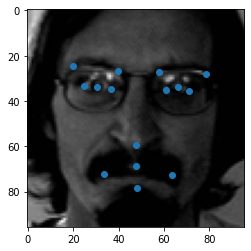

In [ ]:
show_image(X, y, 954)

CNN model

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', input_shape=(96, 96, 1)),
        layers.LeakyReLU(),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.LeakyReLU(),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(128),
        layers.ReLU(),
        layers.Dense(96),
        layers.ReLU(),
        layers.Dense(64),
        layers.ReLU(),
        layers.Dense(30)
    ])
    
    return model

In [ ]:
model = create_model()

model.compile(optimizer='adam',
              loss='huber_loss',
              metrics=['accuracy'])

# Creates a callback to save weights
checkpoint_path = "checkpoint01/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(X, y, batch_size=32, epochs=100, callbacks=[cp_callback])

Epoch 1/100
201/201 [==============================] - ETA: 0s - loss: 11.9758 - accuracy: 0.5340
Epoch 00001: saving model to checkpoint01/cp.ckpt
201/201 [==============================] - 16s 25ms/step - loss: 11.9758 - accuracy: 0.5340
Epoch 2/100
199/201 [============================>.] - ETA: 0s - loss: 6.0950 - accuracy: 0.6801
Epoch 00002: saving model to checkpoint01/cp.ckpt
201/201 [==============================] - 5s 24ms/step - loss: 6.0872 - accuracy: 0.6802
Epoch 3/100
201/201 [==============================] - ETA: 0s - loss: 5.9155 - accuracy: 0.6766
Epoch 00003: saving model to checkpoint01/cp.ckpt
201/201 [==============================] - 5s 24ms/step - loss: 5.9155 - accuracy: 0.6766
Epoch 4/100
200/201 [============================>.] - ETA: 0s - loss: 5.5798 - accuracy: 0.6606
Epoch 00004: saving model to checkpoint01/cp.ckpt
201/201 [==============================] - 5s 25ms/step - loss: 5.5816 - accuracy: 0.6601
Epoch 5/100
200/201 [============================

In [ ]:
# Shows predicted keypoints on image
def show_predicted_image(predictions, index):
    example = predictions[index, :]
    x_values = example[::2]
    y_values = example[1::2]
    example_image = images[index].reshape(96, 96)
    plt.imshow(example_image, cmap='gray')
    plt.scatter(x_values, y_values)
    plt.show()

In [ ]:
test_dataframe = get_test_df()
images = get_images(test_dataframe).reshape(1783, 96, 96, 1)

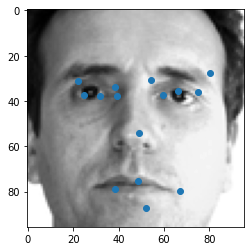

In [ ]:
predictions = model.predict(images)
show_predicted_image(predictions, 318)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, \
     Flatten, BatchNormalization, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import elu, relu
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2

class customCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.epoch = epoch + 1
    if self.epoch % 50 == 0:
      print ('epoch num {}, train acc: {}, validation acc: {}'.format(epoch, logs['mae'], logs['val_mae']))

learning_rate = 1e-3

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.8,
                              patience=25, min_lr=1e-5, verbose=1)

In [19]:
def inception_like(input_layer, filter1, filter2, filter3):
  # 1x1 conv
  conv1 = Conv2D(filter1, (1,1), padding='same', activation='relu')(input_layer)
  bn1 = BatchNormalization()(conv1)
  # 3x3 conv
  conv3 = Conv2D(filter2, (3,3), padding='same', activation='relu')(input_layer)
  bn3 = BatchNormalization()(conv3)
  # 5x5 conv
  conv5 = Conv2D(filter3, (5,5), padding='same', activation='relu')(input_layer)
  bn5 = BatchNormalization()(conv5)
  # 3x3 max pooling
  pool = MaxPooling2D((2,2), strides=(1,1), padding='same')(input_layer)
  # concatenate filters, assumes filters/channels last
  layer_out = Concatenate(axis=-1)([bn3, bn5, pool])
  return layer_out

input_im = Input(shape=(96, 96, 1))

def create_inception_model():
  x1 = inception_like(input_im, 64, 64, 32)
  x1 = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x1)

  x2 = inception_like(x1, 64, 64, 32)
  x2 = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x2)
  
  x2_1 = inception_like(x2, 96, 96, 64)
  x2_1 = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x2_1)  

  x3 = inception_like(x2_1, 96, 128, 64)
  x3 = MaxPooling2D()(x3)

  x3_1 = inception_like(x3, 128, 256, 128)
  x3_1 = GlobalAveragePooling2D()(x3_1)

  x4 = Flatten()(x3_1)
  x4 = Dense(1024, kernel_regularizer=l2(l2=0.03))(x4)
  x4 = Dropout(0.2)(x4)

  pred = Dense(30)(x4)
  model = Model(inputs=input_im, outputs=pred, name='Inception_Like')

  return model

inception_model = create_inception_model()
inception_model.summary()
tf.keras.utils.plot_model(inception_model, show_shapes=True, to_file= r"/content/gdrive/My Drive/vcs/inception_like_model.png", dpi=150)

# Creates a callback to save weights
checkpoint_path2 = "checkpoint02/cp.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path2,
                                                 save_weights_only=True,
                                                 verbose=1)

inception_model.compile(loss='mse', 
                       optimizer=Adam(learning_rate=learning_rate), 
                       metrics=['mae'])

incepotion_model_history = inception_model.fit(X, y, 
                                                  validation_split= 0.2, 
                                                  batch_size=64, epochs=300, 
                                                  callbacks=[customCallbacks(), reduce_lr], verbose=1)

Model: "Inception_Like"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 conv2d_31 (Conv2D)             (None, 96, 96, 64)   640         ['input_3[0][0]']                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 96, 96, 32)   832         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_31 (BatchN  (None, 96, 96, 64)  256         ['conv2d_31[0][0]']              
 ormalization)                                                                       

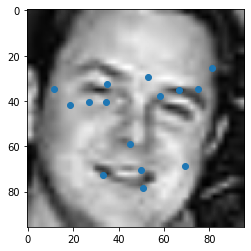

In [26]:
predictions = inception_model.predict(images)
show_predicted_image(predictions, 1033)